In [1]:
#########################################
# 1. IMPORT LIBRARIES & SET GLOBAL VARS #
#########################################

import os
from os.path import exists
import glob
import re
import sys
sys.path.append('../')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import xarray as xr

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import gdown

# Threshold used for selecting reliable voxels.
NCSNR_THRESHOLD = 0.2


from PIL import Image

from sklearn.manifold import MDS
from sklearn.decomposition import PCA


import sys

import pickle

In [2]:
# Load Algonauts data

with open('../algonauts_brain_data_joint_images_8subjects.pkl', 'rb') as f:
    brainData = pickle.load(f)

shared_images = np.load('../algonauts_joint_images_8subjects.npy')
clean_images = shared_images

In [3]:
avail_models = models.list_models(module=torchvision.models)
avail_models

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'googlenet',
 'inception_v3',
 'maxvit_t',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 'regnet_x_32gf',
 'regnet_x_3_2gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_8gf',
 'regnet_y_128gf',
 'regnet_y_16gf',
 'regnet_y_1_6gf',
 'regnet_y_32gf',
 'regnet_y_3_2gf',
 'regnet_y_400mf',
 'regnet_y_800mf',
 'regnet_y_8gf',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext101_64x4d',
 'resnext50_32x4d',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'sh

In [ ]:
# 1000 Imagenet images, one from each category

fnames = [f for f in os.listdir('/mnt/ceph/users/sharvey/decoding/imagenet-sample-images/dataset/test/') if not f.startswith(".")]

images = []
for ind in range(len(fnames)):
    image_path = '/mnt/ceph/users/sharvey/decoding/imagenet-sample-images/dataset/test/' + fnames[ind]
    try:
        img = Image.open(image_path)
        img_array = np.array(img)
        images.append(img_array)
    except Exception as e:
        print(f"Error loading image {image_file}: {e}")

shared_images = images


bwimageidx = []
for i, num in enumerate([len(shared_images[i].shape) for i in range(len(shared_images))]):
    if num < 3:
        bwimageidx.append(i)
        shared_images[i] = np.repeat(shared_images[i][:, :, np.newaxis], 3, axis=2)
        

In [ ]:
# Extract representations resulting from probe inputs image_data for a list of models, and save them individually (takes a long time)

import extract_internal_reps

# internal_reps = []
# model_2nds = []
repDict = {}

model_names = ['resnet50']
weights = 'first'
# image_data = test_image_data[0:1000,:,:,:]
# clean_images = shared_images
batch_size = 32
perm = 0

# permutation = np.array([1, 2, 0])

# if not np.array_equal(np.sort(permutation), np.arange(3)):
#     raise ValueError(f"Permutation array must contain all unique indices from 0 to 2.")

if perm:
    image_data = []
    for i in range(len(shared_images)):
        # permutation = np.random.permutation(3)
        single_image = shared_images[i]
        single_image_perm = single_image[...,permutation[i]]
        image_data.append(single_image_perm)
    # image_data = np.array(image_data)
else:
    image_data = shared_images

for model in model_names:  #avail_models:
    repDict[model] = extract_internal_reps.get_model_activations(model, weights, image_data, batch_size=32, saverep = True, filename = 'algonauts_shared_images_colors_normal')
    print(model + " done")

In [128]:
# Load some saved representations

repDict_cnormal = {}

model_names = ["resnet50", "dinov2_vitb14"]

N_models = len(model_names)
for model_name in model_names:
    with open('../reps/' + model_name + '_algonauts_shared_images_colors_normal.pkl', 'rb') as f:
        new_reps = pickle.load(f)
        repDict_cnormal.update(new_reps)
        print(model_name)

# model_names, _ = zip(*repDict.items())
model_names = [value for value in repDict_cnormal.keys()]
# internal_reps = [value[0] for value in repDict.values()]


resnet50
dinov2_vitb14


In [129]:
layer_names = []
internal_reps = []
layer_models = []

for model_name in model_names:
    layer_names.extend([value for value in repDict_cnormal[model_name].keys()])
    internal_reps.extend([value for value in repDict_cnormal[model_name].values()])
    layer_models.extend([model_name] * len([value for value in repDict_cnormal[model_name].keys()]))


In [ ]:
# Make sure representations are flattened

internal_reps = [internal_reps[i].reshape((internal_reps[i].shape[0], np.prod(list(internal_reps[i].shape[1:])) )) for i in range(len(internal_reps))]

internal_reps = [internal_rep/np.linalg.norm(internal_rep, ord=2) for internal_rep in internal_reps]

[internal_rep.shape for internal_rep in internal_reps]


In [ ]:
import metrics 

dd = metrics.LinearDecodingSimilarityMulti(center_columns=True, a = 0, b = 1, whiten = False, alpha = 0.5)
cached = dd.cache(internal_reps, returnGinv=False) # this part takes a long time
# cached = dd.cache(reps_pcs, returnGinv=False) # this part takes a long time
np.savez('../cached_matrices/Kx_cache_resnet50_DINOv2_vitb14_algonauts_shared_a0b1_all_layers_colors_normal_opnorm.npz', cached, layer_names)




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
Done caching.


In [ ]:
# load previously computed cache

loaded_cache = np.load('../cached_matrices/Kx_cache_resnet50_DINOv2_vitb14_algonauts_shared_a0b1_all_layers_colors_normal_opnorm.npz')

# cached = loaded_cache
cached = loaded_cache["arr_0"]
layer_names = loaded_cache["arr_1"]
layer_names = [str(layer_name) for layer_name in layer_names]

In [ ]:
layer_names

['pixels',
 'feature.0',
 'feature.1',
 'feature.2',
 'feature.3',
 'feature.4',
 'feature.5',
 'feature.6',
 'feature.7',
 'feature.8',
 'feature.9',
 'feature.10',
 'feature.11',
 'feature.12',
 'features',
 'avgpool',
 'classifier',
 'pixels',
 'conv_proj',
 'encoder_layer_0',
 'encoder_layer_1',
 'encoder_layer_2',
 'encoder_layer_3',
 'encoder_layer_4',
 'encoder_layer_5',
 'encoder_layer_6',
 'encoder_layer_7',
 'encoder_layer_8',
 'encoder_layer_9',
 'encoder_layer_10',
 'encoder_layer_11',
 'encoder',
 'heads',
 'pixels',
 'patch_embed',
 'block.0',
 'block.1',
 'block.2',
 'block.3',
 'block.4',
 'block.5',
 'block.6',
 'block.7',
 'block.8',
 'block.9',
 'block.10',
 'block.11',
 'norm',
 'head']

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path, zoom=1):
    return OffsetImage(plt.imread(path), zoom=zoom)

# images = [test_image_data[i,:,:,:] for i in range(1000)]
images = [shared_images[i] for i in range(len(shared_images))]

# metric_type = 'similarity'
metric_type = 'distance'
plot = 'True'
p = 5 # dimension of the projection

# inds = list(range(0,17))
# inds = list(range(17,33))
inds = list(range(34,49))

# inds = list(range(0, len(layer_names)))

dist_mat = np.zeros((len(inds),len(inds)))

dist_task_dict = {}

count1 = 0


for ind1 in inds:
    count2 = 0
    KX = cached[ind1]
    
    for ind2 in inds:
        
        KY = cached[ind2]
        
        if metric_type == 'similarity':
            A = (1/2)*(KX@KY + KY@KX)
        elif metric_type == 'distance':
            A = (KX - KY)@(KX - KY)
        else:
            print('check metric type')
        
        vals, vecs = np.linalg.eig(A)
        
        idx = vals.argsort()[::-1]   
        vals = vals[idx]
        vecs = vecs[:,idx]

        Xw = KX@vecs[:,0:p]
        Yv = KY@vecs[:,0:p]

        if metric_type == 'similarity':
            # dist_mat[count1,count2] = (Xw.T @ Yv) /(np.linalg.norm(Xw) * np.linalg.norm(Yv))
            dist_mat[count1,count2] = np.trace((Xw.T @ Yv)) /(np.linalg.norm(Xw, ord='fro') * np.linalg.norm(Yv, ord='fro'))

        elif metric_type == 'distance':
            dist_mat[count1,count2] = np.linalg.norm(Xw/np.linalg.norm(Xw, ord='fro') - Yv/np.linalg.norm(Yv, ord='fro') , ord='fro' )     #vecs[:,0].T @ A @ vecs[:,0]

        dist_task_dict[(layer_names[ind1], layer_names[ind2])] = {
            'dist': dist_mat[count1,count2],
            'vec': vecs[:,0],
            'vals': vals,
            'KX': KX,
            'KY': KY}

        

        print(layer_names[ind1])
        print(layer_names[ind2])
        
        count2 += 1

        # Plotting

        if plot == 'True':

            x = KX@vecs[:,0]/np.linalg.norm(KX@vecs[:,0])
            y = KY@vecs[:,0]/np.linalg.norm(KY@vecs[:,0])

            # x = vecs[:,0]
            # y = vecs[:,1]

            # x = KX@Cz_1
            # y = KY@Cz_1

            fig, ax = plt.subplots(figsize=(15,15))
            ax.scatter(x, y) 
            # ax.set_xlim(-0.3, 0.6)
            # ax.set_ylim(-0.25, 0.75)

            axes = plt.gca()
            x_min, x_max = axes.get_xlim()
            y_min, y_max = axes.get_ylim()

            # Determine the range for the unity line to cover the visible area
            # Ensure the line extends across the relevant portion of the plot
            unity_line_min = max(x_min, y_min)
            unity_line_max = min(x_max, y_max)

            # Create x and y values for the unity line
            unity_x = np.linspace(unity_line_min, unity_line_max, 2)
            unity_y = unity_x

            # Plot the unity line
            ax.plot(unity_x, unity_y, color='red', linestyle='--', label='Unity Line (y=x)')


            zoom=0.04

            for x0, y0, imgdata in zip(x, y,images):
                img = OffsetImage(imgdata, zoom=zoom)
                # img = Image.fromarray(imgdata, 'RGB')
                ab = AnnotationBbox(img, (x0, y0), frameon=False)
                ax.add_artist(ab)

            plt.savefig('../layer_comparison_images/zxzy_' + metric_type + '_a0b1_' + layer_models[ind1] + '_' + layer_names[ind1] + '_' + layer_models[ind2] + '_' + layer_names[ind2] + '_algonauts_shared_images.pdf', dpi=500)

            plt.close(fig)

#  --- IGNORE ---   <--- This is a comment
    # error_mat[count1] = np.linalg.norm(KX@vecs[:,0] - vecs[:,0])
    # error_mat_color[count1] = np.linalg.norm(KX@C@vecs_c[:,0] - C@vecs_c[:,0])

        
    count1 += 1

# Save the distance task dictionary to a file
with open('../layer_comparison_images/Resnet50_Dinov2_layer_by_layer_task_dict_' + metric_type + '_a0b1_' + 'algonauts_shared_images_p'+ str(p) +'.pkl', 'wb') as f:
    pickle.dump(dist_task_dict, f)

patch_embed
patch_embed
patch_embed
block.0
patch_embed
block.1
patch_embed
block.2
patch_embed
block.3
patch_embed
block.4
patch_embed
block.5
patch_embed
block.6
patch_embed
block.7
patch_embed
block.8
patch_embed
block.9
patch_embed
block.10
patch_embed
block.11
patch_embed
norm
patch_embed
head
block.0
patch_embed
block.0
block.0
block.0
block.1
block.0
block.2
block.0
block.3
block.0
block.4
block.0
block.5
block.0
block.6
block.0
block.7
block.0
block.8
block.0
block.9
block.0
block.10
block.0
block.11
block.0
norm
block.0
head
block.1
patch_embed
block.1
block.0
block.1
block.1
block.1
block.2
block.1
block.3
block.1
block.4
block.1
block.5
block.1
block.6
block.1
block.7
block.1
block.8
block.1
block.9
block.1
block.10
block.1
block.11
block.1
norm
block.1
head
block.2
patch_embed
block.2
block.0
block.2
block.1
block.2
block.2
block.2
block.3
block.2
block.4
block.2
block.5
block.2
block.6
block.2
block.7
block.2
block.8
block.2
block.9
block.2
block.10
block.2
block.11
block.

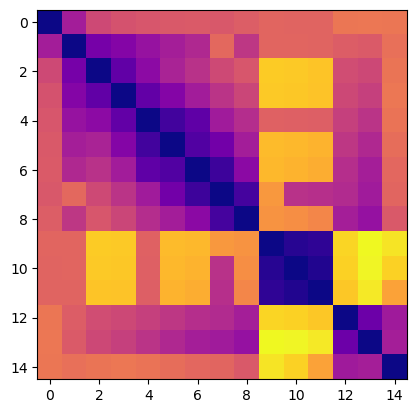

In [125]:
plt.imshow(dist_mat, cmap='plasma')

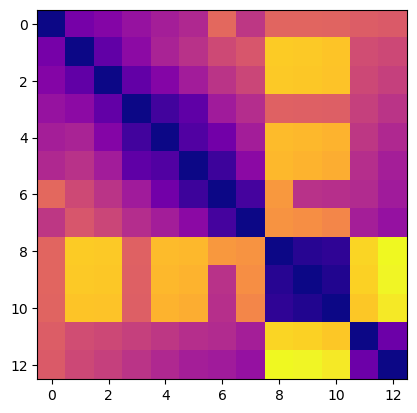

In [126]:
plt.imshow(dist_mat[1:-1,1:-1], cmap='plasma')

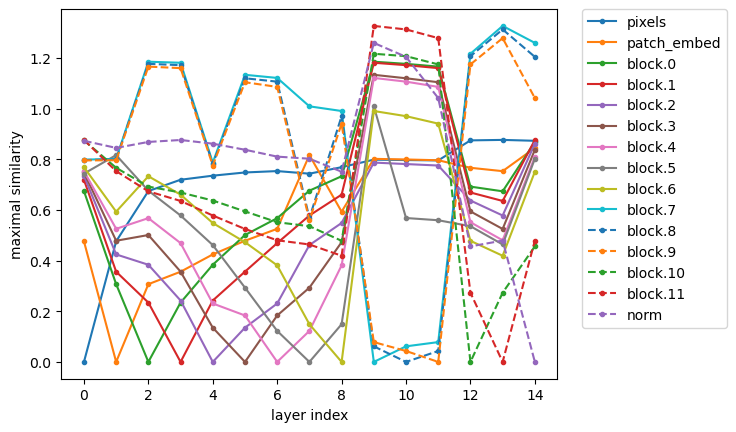

In [127]:
for i in range(0,len(dist_mat)):
    # if i ==0:
    #     continue
    if i > 9:
        plt.plot(dist_mat[i,:],'.--',label=layer_names[i+33])
    else:
        plt.plot(dist_mat[i,:],'.-',label=layer_names[i+33])

    # plt.plot(dist_mat[i,:],'.-',label=layer_names[i])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0)
    plt.xlabel('layer index')
    plt.ylabel('maximal similarity')

    plt.savefig('../layer_comparison_images/DINOv2_layer_by_layer_' + metric_type + '_a0b1_algonauts_shared_images.pdf', dpi=500, bbox_inches='tight')
    
    # plt.yscale('log')

### Inspect 2 layers

In [117]:
ind1 = 44 #2 #13
ind2 = 47 #43 #35 #20 #30

metric_type = 'similarity'
# metric_type = 'distance'

KX = cached[ind1]
KY = cached[ind2]

# KX = cached[ind1]/np.linalg.norm(cached[ind1], ord='fro')
# KY = cached[ind2]/np.linalg.norm(cached[ind2], ord='fro')

if metric_type == 'similarity':
    A = (1/2)*(KX@KY + KY@KX)
    # A = (1/2)*(C.T @ KX@KY @ C + C.T @ KY@KX @ C)
elif metric_type == 'distance':
    # A = C.T @ (KX - KY)@(KX - KY) @ C
    A = (KX - KY)@(KX - KY)
else:
    print('check metric type')

# A = (1/2)*(KY@KY - KY + KX - KX@KY)@(KY@KY - KY + KX - KY@KX)

vals, vecs = np.linalg.eig(A)

idx = vals.argsort()[::-1]   
vals = vals[idx]
vecs = vecs[:,idx]

print(layer_names[ind1])
print(layer_names[ind2])

print(vecs[:,0].T @ A @ vecs[:,0])

block.9
norm
7.803423e-09


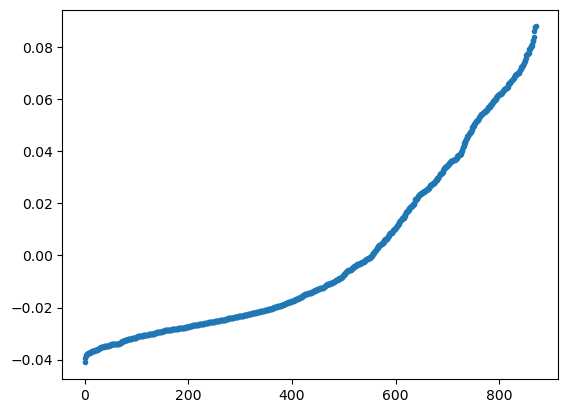

In [118]:
# Pick an eigenvector z

zind = 0
sorted_img_idx = vecs[:,zind].argsort()[::-1]
plt.plot(np.sort(vecs[:,zind]),'.')

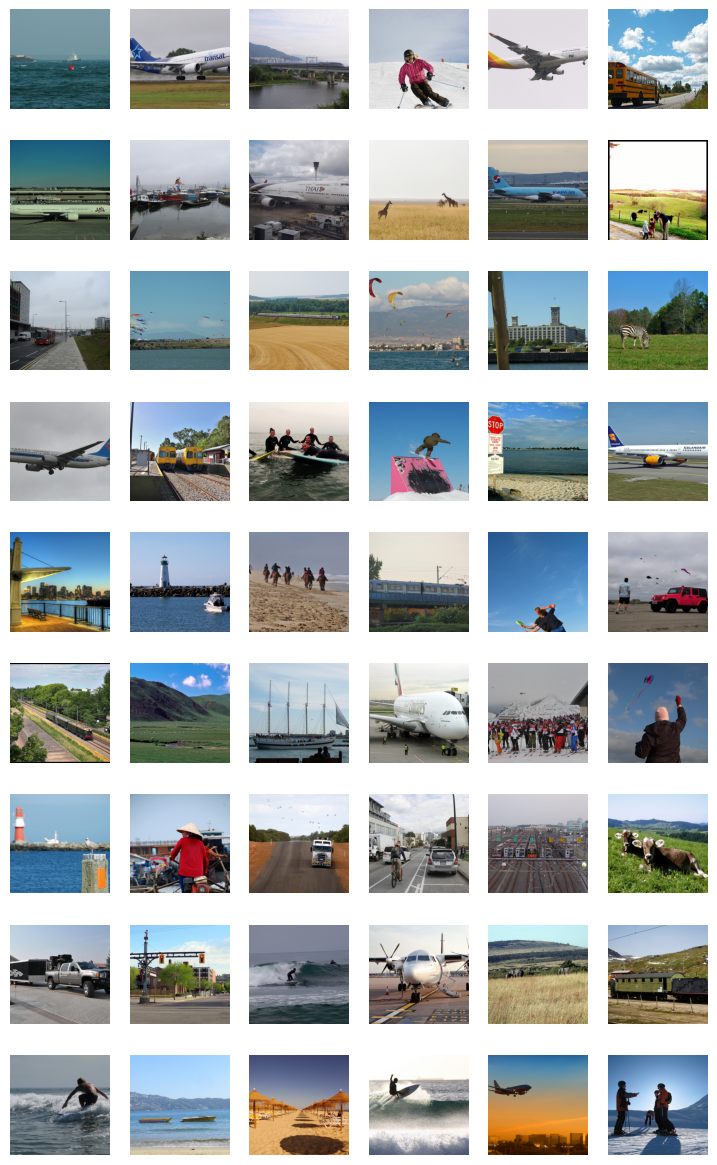

In [119]:
import matplotlib.pyplot as plt

nimgs = 54
ncols = 6
nrows = int(np.ceil(nimgs/ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(9,15))
ind = 0

for row in range(nrows):
    for column in range(ncols):
        if ind == nimgs:
            break
        else:
            # image = test_image_data[sorted_img_idx[ind],:,:,:]
            image = shared_images[sorted_img_idx[ind]]
            ax = axes[row, column]
            # ax.set_title(f"Image ({row}, {column})")
            ax.axis('off')
            ax.imshow(image)
            ind += 1

# plt.savefig('maxmin_image_tiles/distance_maxweights_' + model_names[ind1] + '_' + model_names[ind2] + '_eigvec' + str(zind) + '.pdf')

plt.show()



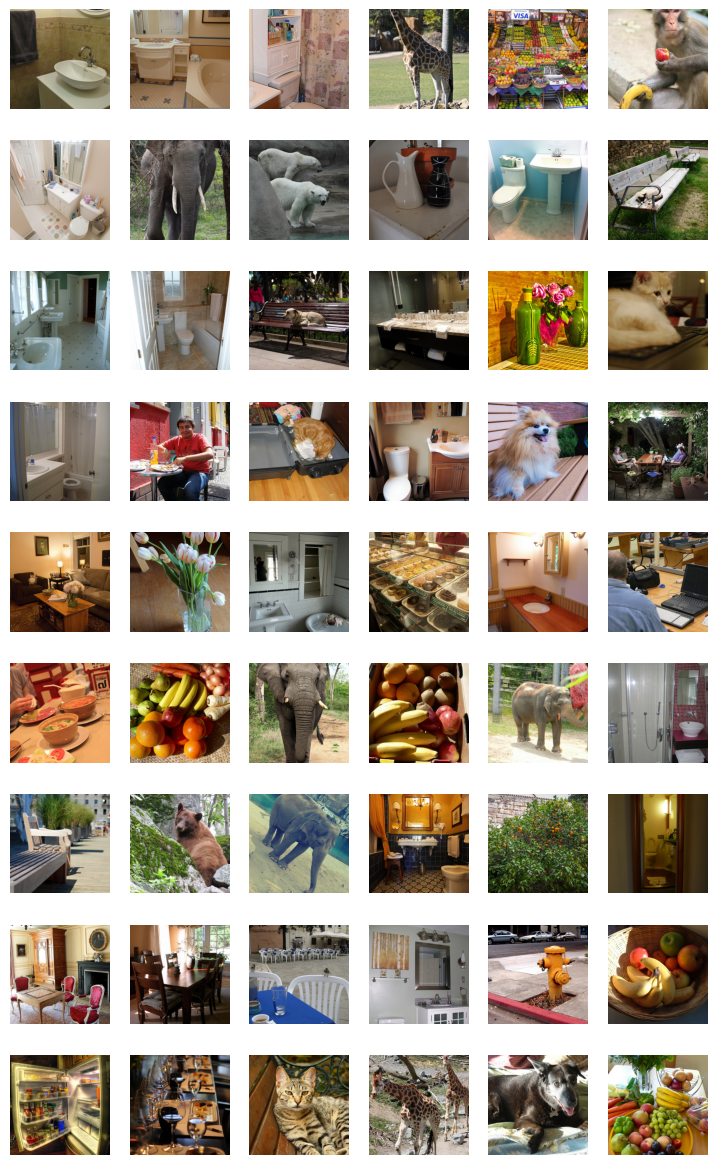

In [120]:
import matplotlib.pyplot as plt

nimgs = 54
ncols = 6
nrows = int(np.ceil(nimgs/ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(9,15))
ind = -1

for row in range(nrows):
    for column in range(ncols):
        if ind == nimgs:
            break
        else:
            # image = test_image_data[sorted_img_idx[ind],:,:,:]
            image = shared_images[sorted_img_idx[ind]]
            ax = axes[row, column]
            # ax.set_title(f"Image ({row}, {column})")
            ax.axis('off')
            ax.imshow(image)
            ind -= 1

# plt.savefig('maxmin_image_tiles/distance_minweights_' + model_names[ind1] + '_' + model_names[ind2] + '_eigvec' + str(zind) + '.pdf')

plt.show()

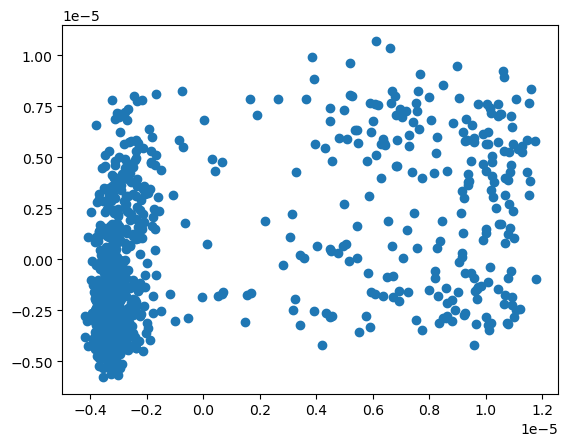

In [121]:
plt.scatter(KX@vecs[:,0], KY@vecs[:,0])

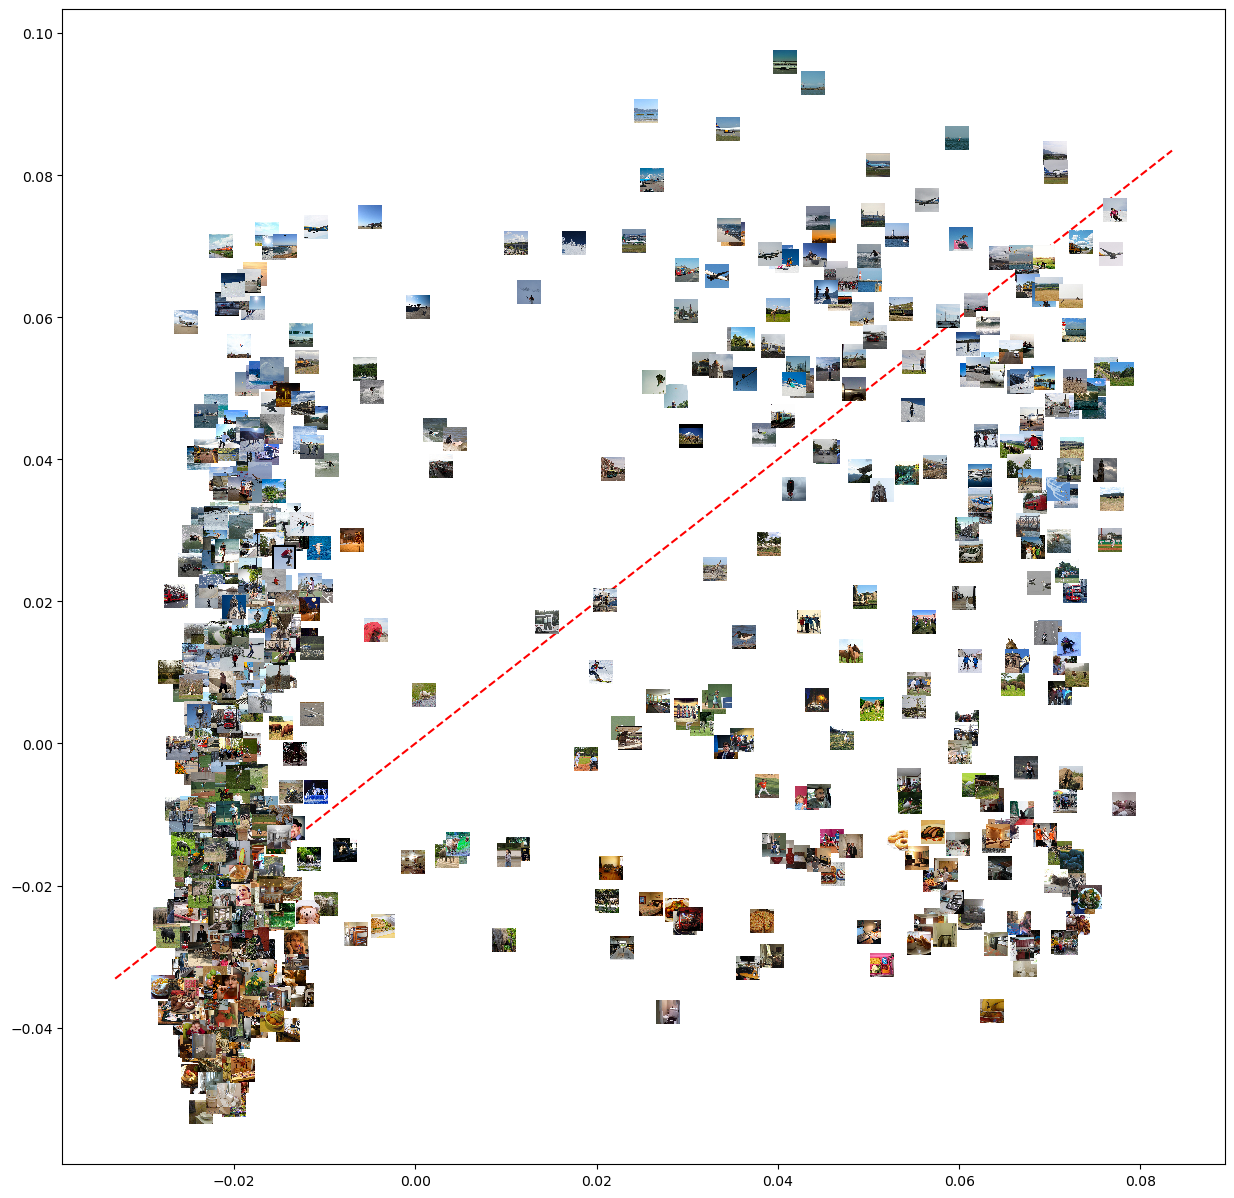

In [122]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path, zoom=1):
    return OffsetImage(plt.imread(path), zoom=zoom)



# images = [test_image_data[i,:,:,:] for i in range(1000)]
images = [shared_images[i] for i in range(len(shared_images))]

vecind = 0

x = KX@vecs[:,vecind]/np.linalg.norm(KX@vecs[:,vecind])
y = KY@vecs[:,vecind]/np.linalg.norm(KY@vecs[:,vecind])

# x = KX@vecs[:,vecind]
# y = KY@vecs[:,vecind]

# x = vecs[:,0]
# y = vecs[:,1]

# x = KX@Cz_1
# y = KY@Cz_1

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(x, y) 
# ax.set_xlim(-0.3, 0.6)
# ax.set_ylim(-0.25, 0.75)

axes = plt.gca()
x_min, x_max = axes.get_xlim()
y_min, y_max = axes.get_ylim()

# Determine the range for the unity line to cover the visible area
# Ensure the line extends across the relevant portion of the plot
unity_line_min = max(x_min, y_min)
unity_line_max = min(x_max, y_max)

# Create x and y values for the unity line
unity_x = np.linspace(unity_line_min, unity_line_max, 2)
unity_y = unity_x

# Plot the unity line
plt.plot(unity_x, unity_y, color='red', linestyle='--', label='Unity Line (y=x)')


zoom=0.04

for x0, y0, imgdata in zip(x, y,images):
    img = OffsetImage(imgdata, zoom=zoom)
    # img = Image.fromarray(imgdata, 'RGB')
    ab = AnnotationBbox(img, (x0, y0), frameon=False)
    ax.add_artist(ab)
# 
# plt.savefig('../maxmin_image_tiles/top2eigenvecs_'+ metric_type +'_a0b1_'+ model_names[2] + '_' + layer_names[ind1] + '_' + model_names[2] + '_' + layer_names[ind2] + '_algonauts_shared_images.pdf', dpi=500)
# 
    

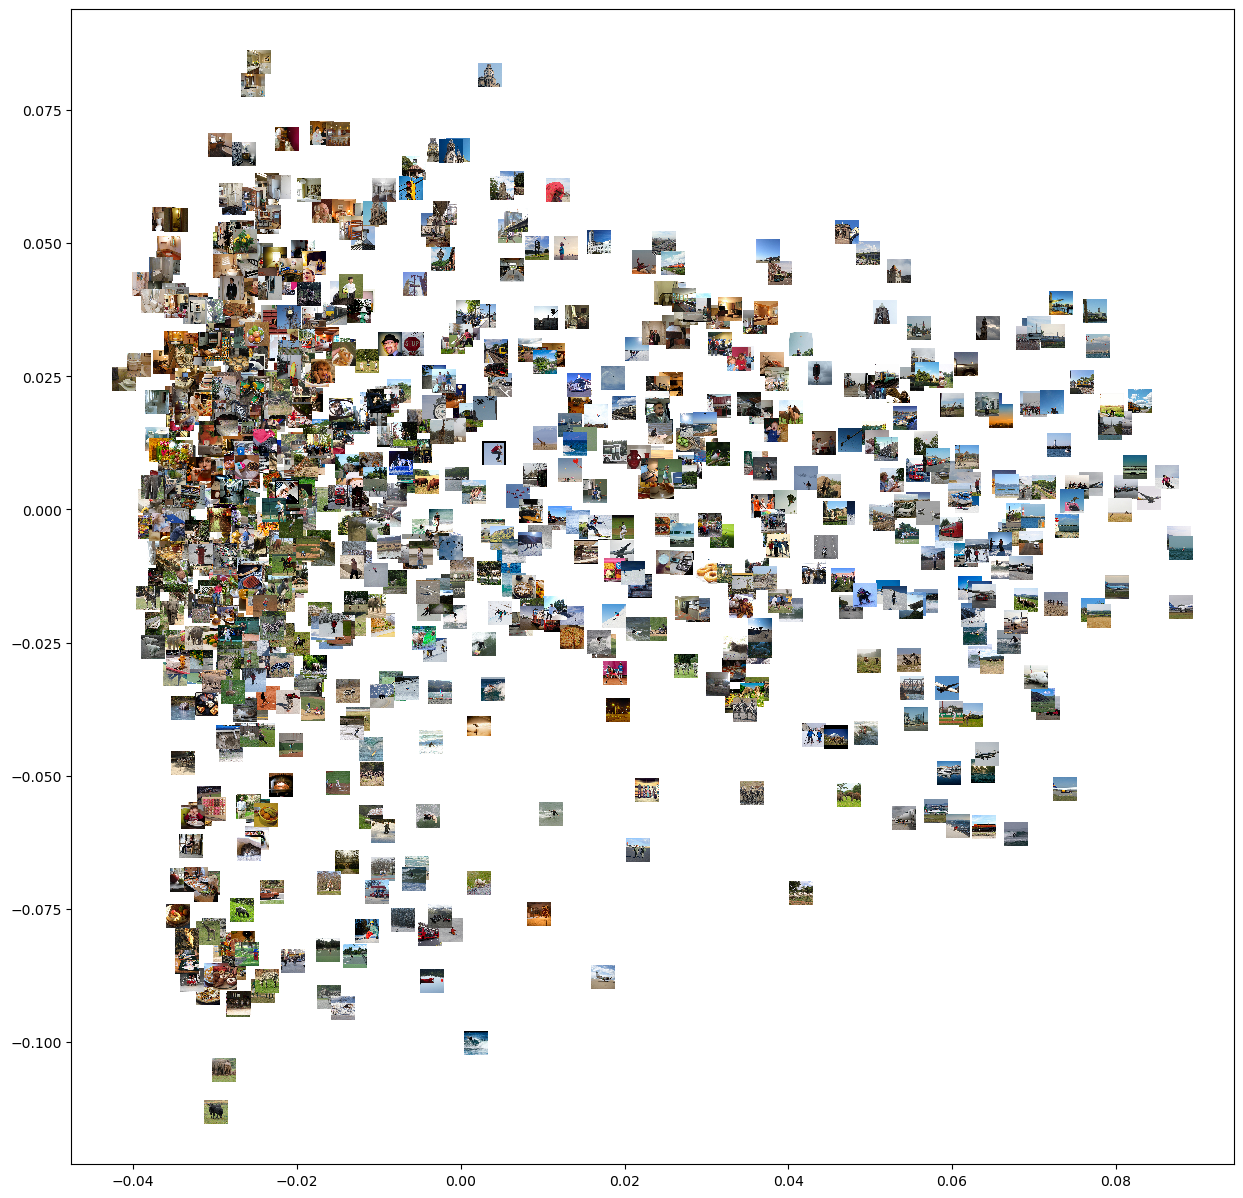

In [123]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path, zoom=1):
    return OffsetImage(plt.imread(path), zoom=zoom)



# images = [test_image_data[i,:,:,:] for i in range(1000)]
images = [shared_images[i] for i in range(len(shared_images))]


x = vecs[:,0]
y = vecs[:,1]

# x = KX@Cz_1
# y = KY@Cz_1

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(x, y) 
# ax.set_xlim(-0.3, 0.6)
# ax.set_ylim(-0.25, 0.75)

axes = plt.gca()
x_min, x_max = axes.get_xlim()
y_min, y_max = axes.get_ylim()

# # Determine the range for the unity line to cover the visible area
# # Ensure the line extends across the relevant portion of the plot
# unity_line_min = max(x_min, y_min)
# unity_line_max = min(x_max, y_max)

# # Create x and y values for the unity line
# unity_x = np.linspace(unity_line_min, unity_line_max, 2)
# unity_y = unity_x

# # Plot the unity line
# plt.plot(unity_x, unity_y, color='red', linestyle='--', label='Unity Line (y=x)')


zoom=0.04

for x0, y0, imgdata in zip(x, y,images):
    img = OffsetImage(imgdata, zoom=zoom)
    # img = Image.fromarray(imgdata, 'RGB')
    ab = AnnotationBbox(img, (x0, y0), frameon=False)
    ax.add_artist(ab)
# 
# plt.savefig('../maxmin_image_tiles/top2eigenvecs_'+ metric_type +'_a0b1_'+ model_names[2] + '_' + layer_names[ind1] + '_' + model_names[2] + '_' + layer_names[ind2] + '_algonauts_shared_images.pdf', dpi=500)
# 
    